# Staging

In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
#%load_ext nb_black
# black formatter f|or jupyter lab
%load_ext lab_black

%run ../src/notebook_env.py


---------------------------------
Working on the host: Joachims-MacBook-Pro.local

---------------------------------
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

---------------------------------
Python interpreter: /opt/miniconda3/envs/idz-parostatus/bin/python

---------------------------------
Root (ROOT) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus
---------------------------------
data (DATA) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/data
---------------------------------
Attaching the following source folders:
/Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/src


**Import modules**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
from util import FdiNomenclaure, less_than_two_non_adjacent_teeth

fdi = FdiNomenclaure()

## Load cohort dataset

In [4]:
fp = DATA.joinpath("processed")
fn = "dmsV_periodontitis_cases.parquet"
file = fp.joinpath(fn)
assert file.exists()

data = pd.read_parquet(file)
data.shape

(927, 748)

## Periodontitis cases (Step 2b - Staging (without `MT`))

<img src=../_img/Staging_wo_MT.png>

If maximum CAL is ≥1 mm, the periodontitis case criterion (interdental CAL is detectable at ≥2 non-adjacent teeth, or buccal or oral CAL ≥3 mm with pocketing ≥3 mm is detectable at ≥2 teeth) is checked. 

In [5]:
staged_patients = {}

### Check for `maximum CAL is ≥1 mm` 
Except 90 special staging case no CAL measurement

In [6]:
_max_CAL_geg_1_mm = (data[["maxCALappr", "maxCALbo"]] >= 1).any(axis=1).sum()
recall_no_CAL_staging_case = 90
assert (
    _max_CAL_geg_1_mm == data.shape[0] - recall_no_CAL_staging_case
), _max_CAL_geg_1_mm

### Check for interdental CAL is detectable at ≥2 non-adjacent teeth

Except 36 special staging case no CAL measurement

In [7]:
pattern = r"maxCALappr\d{2}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
interCAL_geq2_NA_tooth = data[cols].copy()
interCAL_geq2_NA_tooth.columns = [str(x[-2:]) for x in interCAL_geq2_NA_tooth.columns]
interCAL_geq2_NA_tooth = interCAL_geq2_NA_tooth[[str(x) for x in fdi.full_dentition]]
interCAL_geq2_NA_tooth_idx = less_than_two_non_adjacent_teeth(
    interCAL_geq2_NA_tooth, fdi.full_dentition
)
recall_few_teeth_staging = 36
assert len(interCAL_geq2_NA_tooth_idx) - recall_few_teeth_staging == 0, len(
    interCAL_geq2_NA_tooth_idx
)

### Check for buccal or oral CAL ≥3 mm with pocketing ≥3 mm (at any site) is detectable at ≥2 teeth
Except 36 special staging case no CAL measurement

In [8]:
pattern = r"maxCALbo\d{2}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
boCAL_geq2_NA_tooth = data[cols].copy()
boCAL_geq2_NA_tooth.columns = [str(x[-2:]) for x in boCAL_geq2_NA_tooth.columns]
boCAL_geq2_NA_tooth = boCAL_geq2_NA_tooth[[str(x) for x in fdi.full_dentition]]
boCAL_geq2_NA_tooth_idx = less_than_two_non_adjacent_teeth(
    boCAL_geq2_NA_tooth, fdi.full_dentition
)
assert len(boCAL_geq2_NA_tooth_idx) - recall_few_teeth_staging == 0, len(
    boCAL_geq2_NA_tooth_idx
)

## Occluding pairs

Staging can be modified by the number of missing teeth attributed to periodontitis or the presence of at least one complexity factor (maximum PD, having less than 10 opposing pairs) irrespective of maximum interdental CAL (Papapanou et al., 2018). 

In [9]:
pattern = r"zb\d{2}$"
cols = data.columns[[bool(re.match(pattern, c)) for c in data.columns]]
occluding_pairs = data[cols].copy()
occluding_pairs.columns = [str(x[-2:]) for x in occluding_pairs.columns]
# occluding_pairs.head()

In [10]:
data.shape

(927, 748)

In [11]:
# pd.melt(occluding_pairs)["value"].unique()

In [12]:
inclusion_criteria = [
    "Ohne Zahnbefund",
    "Vollkrone",
    "Ankerkrone",
    "Ersetzter Zahn",
    # "Fehlender, nicht ersetzter Zahn",
    "Brückenglied",
    "Implantat mit festsitzendem Zahnersatz",
    "Implantat mit herausnehmbarem Zahnersatz",
    # "Extrahiert, wegen Karies",
    "Teilkrone (auch Veneer)",
]

927


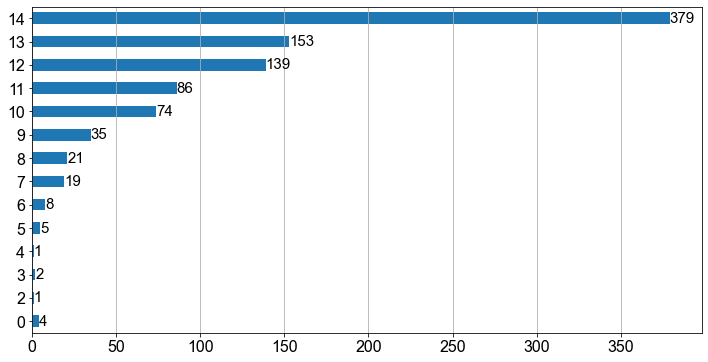

In [13]:
upper_bool = (
    occluding_pairs[[str(x) for x in fdi.upper]].isin(inclusion_criteria)
).rename(columns=dict(zip([str(x) for x in fdi.upper], range(len(fdi.upper)))))

lower_bool = (
    occluding_pairs[[str(x) for x in fdi.lower]].isin(inclusion_criteria)
).rename(columns=dict(zip([str(x) for x in fdi.lower], range(len(fdi.lower)))))

pairs_bool = upper_bool & lower_bool
ax = (pairs_bool).sum(axis=1).value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(data.shape[0])

In [14]:
pairs_idx = pairs_bool.loc[pairs_bool.sum(axis=1) < 10].index
occlusal_pair_case = data.loc[pairs_idx].copy()
staged_patients["occlusal_pair_case"] = occlusal_pair_case
occlusal_pair_case["classification"] = "Stage_IV"
occlusal_pair_case.shape

(96, 749)

In [15]:
print(data.shape[0])
try:
    data = data.drop(occlusal_pair_case.index)
except:
    pass
print(data.shape[0])

927
831


> ### Excurse _What if we would consider all MT as being lost due to periodontitis?_ (see Step 2a - Staging (with `MT`))

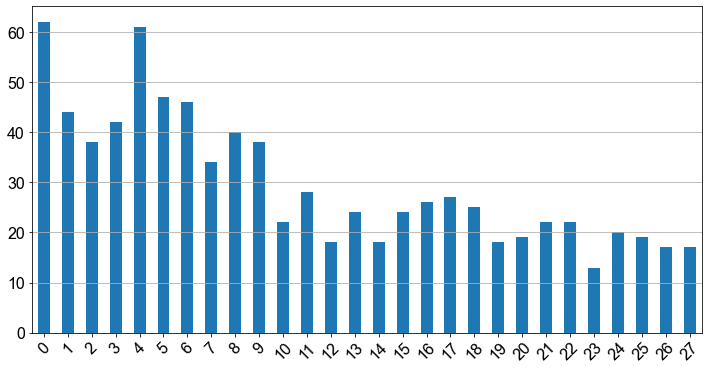

In [16]:
mt = (28 - data["zahnzahl"]).astype(int)
ax = mt.value_counts().sort_index().plot.bar(rot=45)
ax.grid(axis="y")

#### `occlusal pairs < 10 & mt > 4`

In [17]:
len(set(list(mt[mt > 4].index) + list(occlusal_pair_case.index)))

680

> Such an apporach would result in a very large number of participant to be assigned to `Stage IV` right away.

### `Maximum interdental CAL ≥5 mm`

In [18]:
cond_geq5 = data[["maxCALappr"]].max(axis=1) >= 5

In [19]:
maxCAL_geq5_case = data.loc[cond_geq5].copy()
staged_patients["maxCAL_geq5_case"] = maxCAL_geq5_case
maxCAL_geq5_case["classification"] = "Stage_IV"

In [20]:
pattern = r"maxCALappr|\d{2}"
cols = maxCAL_geq5_case.columns[
    [bool(re.match(pattern, c)) for c in maxCAL_geq5_case.columns]
]
maxCAL_geq5_case["affected_teeth"] = (maxCAL_geq5_case[cols] >= 5).sum(axis=1)

592


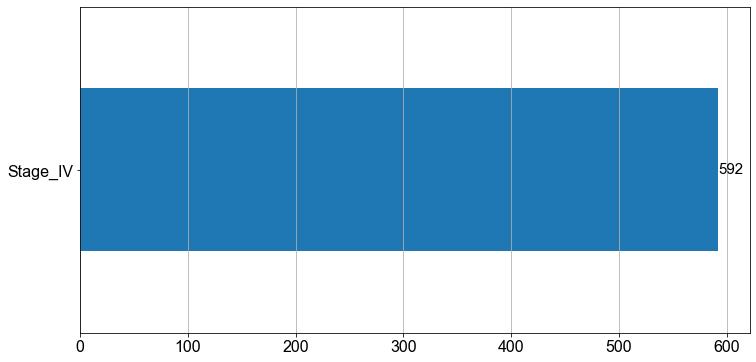

In [21]:
ax = maxCAL_geq5_case["classification"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(maxCAL_geq5_case.shape[0])

In [22]:
print(data.shape[0])
try:
    data = data.drop(maxCAL_geq5_case.index)
except:
    pass
print(data.shape[0])

831
239


### `Maximum interdental CAL 3-4 mm`

In [23]:
cond_3to4mm = (data[["maxCALappr"]].max(axis=1) >= 3) & (
    data[["maxCALappr"]].max(axis=1) <= 4
)

In [24]:
cond_3to4mm_case = data.loc[cond_3to4mm].copy()
cond_3to4mm_case.shape

(149, 748)

In [25]:
pattern = r"st\d{2}\w{4}$"
cols = cond_3to4mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_3to4mm_case.columns]
]
cond_PD_leq5 = cond_3to4mm_case[cols].max(axis=1) <= 5  # II
cond_PD_geq6 = cond_3to4mm_case[cols].max(axis=1) >= 6  # III

In [26]:
# cond_3to4mm_case
cond_3to4mm_case.loc[cond_PD_geq6, "classification"] = "Stage_III"
cond_3to4mm_case.loc[cond_PD_leq5, "classification"] = "Stage_II"
staged_patients["cond_3to4mm_case"] = cond_3to4mm_case

In [27]:
pattern = r"maxCALappr|\d{2}"
cols = cond_3to4mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_3to4mm_case.columns]
]
cond_3to4mm_case["affected_teeth"] = (
    (cond_3to4mm_case[cols] >= 3) & (cond_3to4mm_case[cols] <= 4)
).sum(axis=1)

149


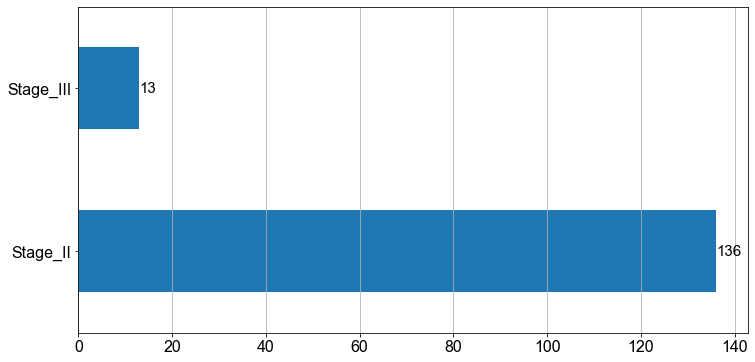

In [28]:
ax = cond_3to4mm_case["classification"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(cond_3to4mm_case.shape[0])

In [29]:
print(data.shape[0])
try:
    data = data.drop(cond_3to4mm_case.index)
except:
    pass
print(data.shape[0])

239
90


### `Maximum interdental CAL 1-2 mm`

In [30]:
cond_1to2mm = (data[["maxCALappr"]].max(axis=1) >= 1) & (
    data[["maxCALappr"]].max(axis=1) <= 2
)

In [31]:
cond_1to2mm_case = data.loc[cond_1to2mm].copy()
cond_1to2mm_case.shape

(4, 748)

In [32]:
pattern = r"st\d{2}\w{4}$"
cols = cond_1to2mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_1to2mm_case.columns]
]
cond_PD_leq4 = cond_1to2mm_case[cols].max(axis=1) <= 4  # I
cond_PD_eq5 = cond_1to2mm_case[cols].max(axis=1) == 5  # II
cond_PD_geq6 = cond_1to2mm_case[cols].max(axis=1) >= 6  # III

In [33]:
cond_1to2mm_case.loc[cond_PD_leq4, "classification"] = "Stage_I"
cond_1to2mm_case.loc[cond_PD_eq5, "classification"] = "Stage_II"
cond_1to2mm_case.loc[cond_PD_geq6, "classification"] = "Stage_III"

staged_patients["cond_1to2mm_case"] = cond_1to2mm_case

In [34]:
pattern = r"maxCALappr|\d{2}"
cols = cond_1to2mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_1to2mm_case.columns]
]
cond_1to2mm_case["affected_teeth"] = (
    (cond_1to2mm_case[cols] >= 1) & (cond_1to2mm_case[cols] <= 2)
).sum(axis=1)

4


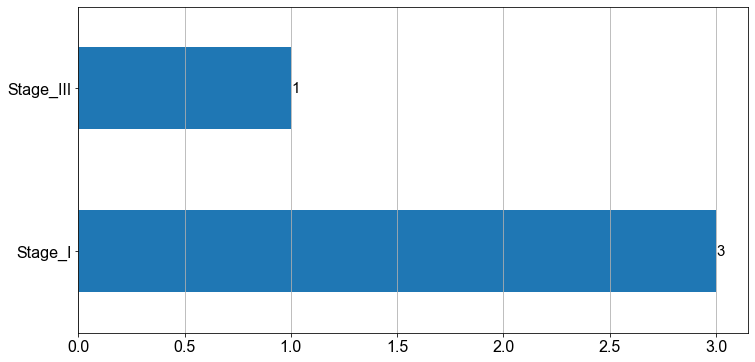

In [35]:
ax = cond_1to2mm_case["classification"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(cond_1to2mm_case.shape[0])

In [36]:
print(data.shape[0])
try:
    data = data.drop(cond_1to2mm_case.index)
except:
    pass
print(data.shape[0])

90
86


### `No interdental CAL measurements`

In [37]:
cond_0mm = data[["maxCALappr"]].max(axis=1) == 0
cond_0mm_case = data.loc[cond_0mm].copy()
cond_0mm_case.shape

(2, 748)

In [38]:
pattern = r"st\d{2}\w{4}$"
cols = cond_0mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_0mm_case.columns]
]
cond_PD_leq4 = cond_0mm_case[cols].max(axis=1) <= 4  # I
cond_PD_eq5 = cond_0mm_case[cols].max(axis=1) == 5  # II
cond_PD_geq6 = cond_0mm_case[cols].max(axis=1) >= 6  # III

In [39]:
cond_0mm_case.loc[cond_PD_leq4, "classification"] = "Stage_I"
cond_0mm_case.loc[cond_PD_eq5, "classification"] = "Stage_II"
cond_0mm_case.loc[cond_PD_geq6, "classification"] = "Stage_III"

staged_patients["cond_0mm_case"] = cond_0mm_case

In [40]:
pattern = r"maxCALappr|\d{2}"
cols = cond_0mm_case.columns[
    [bool(re.match(pattern, c)) for c in cond_0mm_case.columns]
]
cond_0mm_case["affected_teeth"] = 0

2


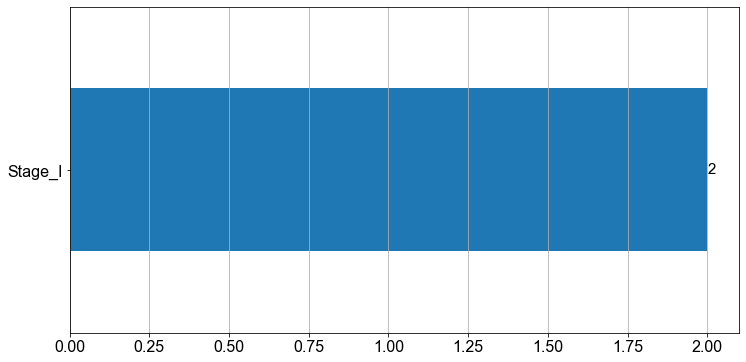

In [41]:
ax = cond_0mm_case["classification"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(cond_0mm_case.shape[0])

In [42]:
print(data.shape[0])
try:
    data = data.drop(cond_0mm_case.index)
except:
    pass
print(data.shape[0])

86
84


### Leftover due to no CAL measurements

In [43]:
cond_noCAL_case = data.copy()
cond_noCAL_case.shape

(84, 748)

In [44]:
pattern = r"st\d{2}\w{4}$"
cols = cond_noCAL_case.columns[
    [bool(re.match(pattern, c)) for c in cond_noCAL_case.columns]
]
cond_PD_leq4 = cond_noCAL_case[cols].max(axis=1) <= 4  # I
cond_PD_eq5 = cond_noCAL_case[cols].max(axis=1) == 5  # II
cond_PD_geq6 = cond_noCAL_case[cols].max(axis=1) >= 6  # III

In [45]:
cond_noCAL_case.loc[cond_PD_leq4, "classification"] = "Stage_I"
cond_noCAL_case.loc[cond_PD_eq5, "classification"] = "Stage_II"
cond_noCAL_case.loc[cond_PD_geq6, "classification"] = "Stage_III"

staged_patients["noCAL_case"] = cond_noCAL_case

84


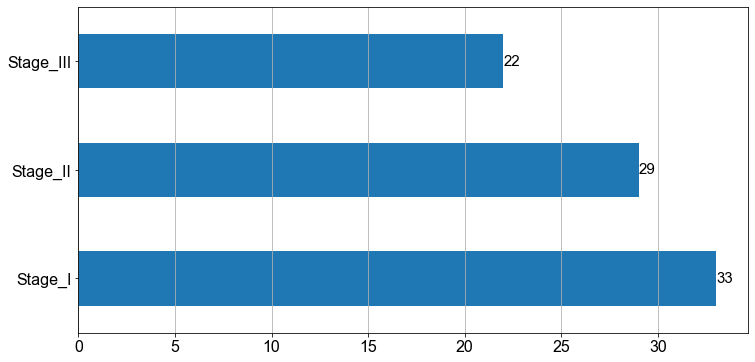

In [46]:
ax = cond_noCAL_case["classification"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(cond_noCAL_case.shape[0])

## Save to disk

In [47]:
fn = "dmsV_staged_periodontitis_cases.parquet"
fp = DATA.joinpath("processed", fn)

_staged_patients = []
for _, v in staged_patients.items():
    _staged_patients.append(v)
_staged_patients = pd.concat(_staged_patients)
_staged_patients.to_parquet(fp)
assert fp.exists(), fp

### Save dict

In [48]:
out = staged_patients

***